# Online Joint State and Parameter Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

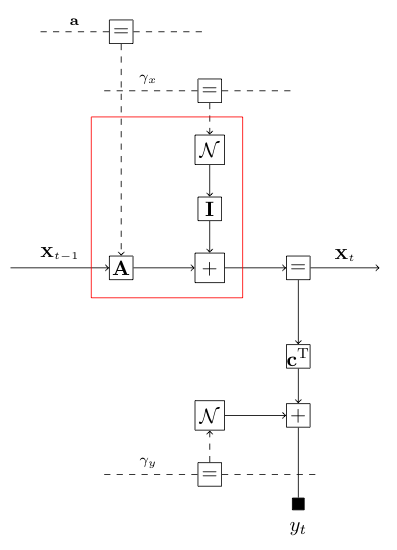

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precisions $\gamma_x=1$, $\gamma_y=\frac{1}{2}$.

In [35]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data, generate_sin
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [36]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
pn_var = a_w/b_w # process noise variance
#coefs, x = generate_data(1000, ARorder, 1, noise_variance=pn_var)
#x = use_data("../data/daily-minimum-temperatures.csv", ARorder)
coefs, x = generate_sin(100, tiny)
mn_var = 1.0 # measurement noise variance
# Observations
y = [xi[1] + sqrt(mn_var)*randn() for xi in x[ARorder:end]]

99-element Array{Float64,1}:
  0.15925406103727688
 -1.2906573028820942 
 -0.8588453842879208 
  0.5284202487416071 
  0.6240799308637008 
  2.7956153138998054 
  0.2804513951115347 
 -0.1463258562674259 
 -1.3514533939654987 
  0.12075601253192203
  1.4391405395728003 
  1.834538030755153  
  1.6547853146977962 
  ⋮                  
  0.8348493054966378 
 -1.792336190332898  
 -3.7260368559961594 
  0.4081311532919337 
 -0.22598863680113312
  0.4325810145479407 
  0.9337679229785446 
  0.5217633527137447 
 -0.21207714213364975
  0.8019635265987552 
 -1.5261926510063653 
  0.9201250449550109 

In [37]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, mn_var^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10132710347462628554 -->
 
 10132710347462628554 
 
 clamp_4 
 
<!-- 422798079969939806 -->
 
 422798079969939806 
 
 dot 
 dotproduct_1 
 
<!-- 422798079969939806--10132710347462628554 -->
 
 422798079969939806--10132710347462628554 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 15813189264884967166 -->
 
 15813189264884967166 
 
 Autoregression 
 autoregression_1 
 
<!-- 422798079969939806--15813189264884967166 -->
 
 422798079969939806--15813189264884967166 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 8672883997569711569 -->
 
 8672883997569711569 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 422798079969939806--8672883997569711569 -->
 
 422798079969939806--8672883997569711569 
 
 y_t 
 1 out 
 1 out 
 
<!-- 17278928572286472 -->
 
 17278928572286472 
 
 placeholder_w_a_t 
 
<!-- 8550786626469849882 -->
 
 8550786626469849882 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 17278928572286472--8550786626469849882 -->
 
 17278928572286472--8550786626469849882 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 3981338347240656791 -->
 
 3981338347240656791 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12483108105160938859 -->
 
 12483108105160938859 
 
 clamp_2 
 
<!-- 12836987758769466506 -->
 
 12836987758769466506 
 
 placeholder_m_x_t_prev 
 
<!-- 12836987758769466506--3981338347240656791 -->
 
 12836987758769466506--3981338347240656791 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 7202135389213509611 -->
 
 7202135389213509611 
 
 clamp_1 
 
<!-- 15611699182757345095 -->
 
 15611699182757345095 
 
 clamp_3 
 
<!-- 12088327166479079587 -->
 
 12088327166479079587 
 
 placeholder_m_y_t 
 
<!-- 12088327166479079587--8672883997569711569 -->
 
 12088327166479079587--8672883997569711569 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 11104771226364124774 -->
 
 11104771226364124774 
 
 placeholder_w_x_t_prev 
 
<!-- 11104771226364124774--3981338347240656791 -->
 
 11104771226364124774--3981338347240656791 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 15996701571768960263 -->
 
 15996701571768960263 
 
 Gam 
 gamma_1 
 
<!-- 15996701571768960263--12483108105160938859 -->
 
 15996701571768960263--12483108105160938859 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 15996701571768960263--7202135389213509611 -->
 
 15996701571768960263--7202135389213509611 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 15813189264884967166--3981338347240656791 -->
 
 15813189264884967166--3981338347240656791 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 15813189264884967166--8550786626469849882 -->
 
 15813189264884967166--8550786626469849882 
 
 a 
 1 out 
 3 a 
 
<!-- 15813189264884967166--15996701571768960263 -->
 
 15813189264884967166--15996701571768960263 
 
 w 
 1 out 
 4 W 
 
<!-- 7038444085816623212 -->
 
 7038444085816623212 
 
 placeholder_m_a_t 
 
<!-- 7038444085816623212--8550786626469849882 -->
 
 7038444085816623212--8550786626469849882 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 8672883997569711569--15611699182757345095 -->
 
 8672883997569711569--15611699182757345095 
 
 clamp_3 
 1 out 
 3 w

In [38]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [49]:
# Define values for prior statistics
m_a_0 = ones(ARorder)
w_a_0 = 0.01*diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = 0.0001*diagAR(ARorder)

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [50]:
marginals = Dict()
# VMP iterations
n_its = 10

# Storage for estimations
means = []
precisions = []
real = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs = []
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    push!(means, m_x_prev[t][1])
    push!(precisions, w_x_prev[t][1])
    push!(WMSEs, wmse(real[1:t], means, 1 ./ precisions))
end

In [51]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=0.32460568516642857
Δ(estimated, noise)=0.3940104513824531
Δ(noise, actual)=0.9423138564299148


In [52]:
mean(marginals[:a])

2-element Array{Float64,1}:
  0.0008056587032923105
 -0.0007892070481173676

In [43]:
using Plots

scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpMqEJr5", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000080.png", "000081.png", "000082.png", "000083.png", "000084.png", "000085.png", "000086.png", "000087.png", "000088.png", "000089.png"])

In [44]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

In [39]:
# Plotting MSE
anim = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [40]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")

# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 1.0$ and $\gamma_y = \frac{1}{2}$

In [29]:
rwg = FactorGraph()

# declare priors as random variables
@RV m_x_t_min
@RV w_x_t_min
@RV x_t_min ~ GaussianMeanPrecision(m_x_t_min, w_x_t_min)

@RV n_t ~ GaussianMeanPrecision(0.0, 1.0)
@RV x_t = x_t_min + n_t
@RV m_t ~ GaussianMeanPrecision(0.0, mn_var^-1)
@RV y_t = x_t + m_t

# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min)
placeholder(w_x_t_min, :w_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11352158112792681318 -->
 
 11352158112792681318 
 
 + 
 addition_1 
 
<!-- 4451820448753754204 -->
 
 4451820448753754204 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 11352158112792681318--4451820448753754204 -->
 
 11352158112792681318--4451820448753754204 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 2485982185312041800 -->
 
 2485982185312041800 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 11352158112792681318--2485982185312041800 -->
 
 11352158112792681318--2485982185312041800 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 14722357653876362698 -->
 
 14722357653876362698 
 
 clamp_4 
 
<!-- 1215420121463430102 -->
 
 1215420121463430102 
 
 clamp_1 
 
<!-- 4451820448753754204--1215420121463430102 -->
 
 4451820448753754204--1215420121463430102 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 7010598137782358252 -->
 
 7010598137782358252 
 
 clamp_2 
 
<!-- 4451820448753754204--7010598137782358252 -->
 
 4451820448753754204--7010598137782358252 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 223407100827183022 -->
 
 223407100827183022 
 
 placeholder_w_x_t_min 
 
<!-- 223407100827183022--2485982185312041800 -->
 
 223407100827183022--2485982185312041800 
 
 w_x_t_min 
 3 w 
 1 out 
 
<!-- 12004931067042307232 -->
 
 12004931067042307232 
 
 placeholder_m_x_t_min 
 
<!-- 12004931067042307232--2485982185312041800 -->
 
 12004931067042307232--2485982185312041800 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 1478318228721976585 -->
 
 1478318228721976585 
 
 clamp_3 
 
<!-- 2948961726325459057 -->
 
 2948961726325459057 
 
 + 
 addition_2 
 
<!-- 2948961726325459057--11352158112792681318 -->
 
 2948961726325459057--11352158112792681318 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 7057787624120964185 -->
 
 7057787624120964185 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 2948961726325459057--7057787624120964185 -->
 
 2948961726325459057--7057787624120964185 
 
 m_t 
 1 out 
 3 in2 
 
<!-- 3719008683189871614 -->
 
 3719008683189871614 
 
 placeholder_y_t 
 
<!-- 3719008683189871614--2948961726325459057 -->
 
 3719008683189871614--2948961726325459057 
 
 y_t 
 1 out 
 1 out 
 
<!-- 7057787624120964185--14722357653876362698 -->
 
 7057787624120964185--14722357653876362698 
 
 clamp_4 
 1 out 
 3 w 
 
<!-- 7057787624120964185--1478318228721976585 -->
 
 7057787624120964185--1478318228721976585 
 
 clamp_3 
 1 out 
 2 m

In [30]:
algo = sumProductAlgorithm(x_t)
eval(Meta.parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
w_x_0 = 0.01

n_samples = length(y)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_min = m_x_0
w_x_t_min = w_x_0

# Storage for estimations
means_rw = []
precisions_rw = []
real_rw = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs_rw = []

for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t        => y[t],
                :m_x_t_min => m_x_t_min,
                :w_x_t_min => w_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x_t_min = mean(marginals[:x_t])
    w_x_t_min = var(marginals[:x_t])^-1
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    w_x[t] = w_x_t_min
    push!(means_rw, m_x_t_min)
    push!(precisions_rw, w_x_t_min)
    push!(WMSEs_rw, wmse(real[1:t], means_rw, 1 ./ precisions_rw))
end

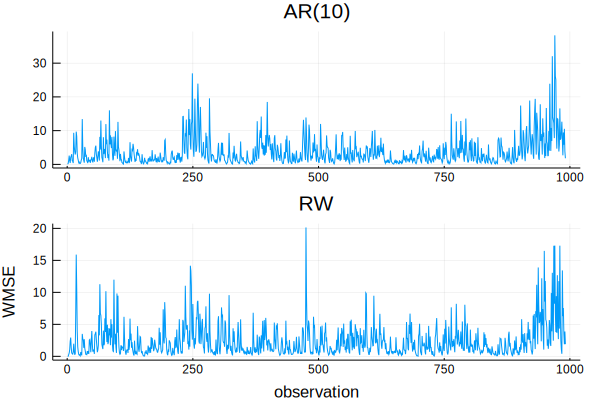

In [31]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", label="")
pRW = plot(WMSEs_rw, xlabel="observation", ylabel="WMSE", title="RW", label="")
plot(pAR, pRW, layout=(2,1))

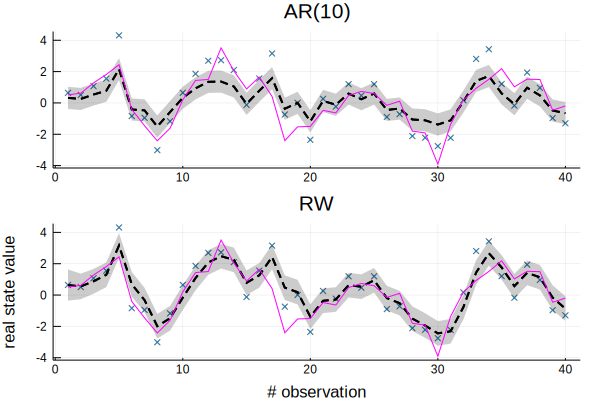

In [32]:
from = 1
upto = 40 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_x[from:upto], m_x[from:upto]], fillrange=[m_x[from:upto] -
      scale .* sqrt.(v_x[from:upto]), m_x[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="# observation", ylabel="real state value", title="RW")


v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[from:upto], estimated[from:upto]], fillrange=[estimated[from:upto] -
      scale .* sqrt.(v_x[from:upto]), estimated[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, layout=(2,1), legend=false)

In [33]:
sum(WMSEs)

3630.8892426342804

In [34]:
sum(WMSEs_rw)

2371.142701911306